In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

## Load and Merge

In [2]:
vu = (pd.read_csv(os.getcwd() + "/data/tourism/vanuatu/intermediate/vu_monthly_visitor.csv")
        .drop("Unnamed: 0", axis=1))
vu["date"] = [str((int(y))) + "-" + str((int(m))) for y, m in zip(vu["Year"], vu["month"])]
vu["date"] = pd.to_datetime(vu["date"])
vu = (vu[vu.date >= "2004-01-01"].reset_index().drop("index", axis=1))

In [3]:
oceania_ci = (pd.read_csv(os.getcwd() + "/data/tourism/oceania_covid_stringency.csv")
              .drop("Unnamed: 0", axis=1))
oceania_ci["date"] = pd.to_datetime(oceania_ci["date"] )
oceania_ci.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [4]:
vu = (vu.merge(oceania_ci[["date", "stringency_index"]], how="left", on="date")
        .rename({"stringency_index": "covid"}, axis=1)
        .fillna(0))
vu.head(5)

,Year,Month,Australia,New Zealand,New Caledonia,Other PIC,Europe,North America,Japan,China,Other Countries,Total,fileyear,Not Stated,month,date,covid
0,2004.0,Jan,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,1.0,2004-01-01,0.0
1,2004.0,Feb,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,2.0,2004-02-01,0.0
2,2004.0,Mar,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,3.0,2004-03-01,0.0
3,2004.0,Apr,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,4.0,2004-04-01,0.0
4,2004.0,May,2076.0,491.0,588.0,121.0,228.0,149.0,61.0,0.0,78.0,3792.0,2005.0,0.0,5.0,2004-05-01,0.0


## SARMIAX

In [5]:
get_adf_df(vu, ["Total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-2.512493,0.112464,13.0,209.0,-3.462032,-2.875471,-2.574195


training size : 211, testing size : 12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=616.054, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=640.338, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=583.267, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=584.257, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=638.380, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=614.655, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=584.101, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=578.056, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=587.821, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=587.993, Time=0.19 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=608.144, Time=0.16 sec
 ARIMA

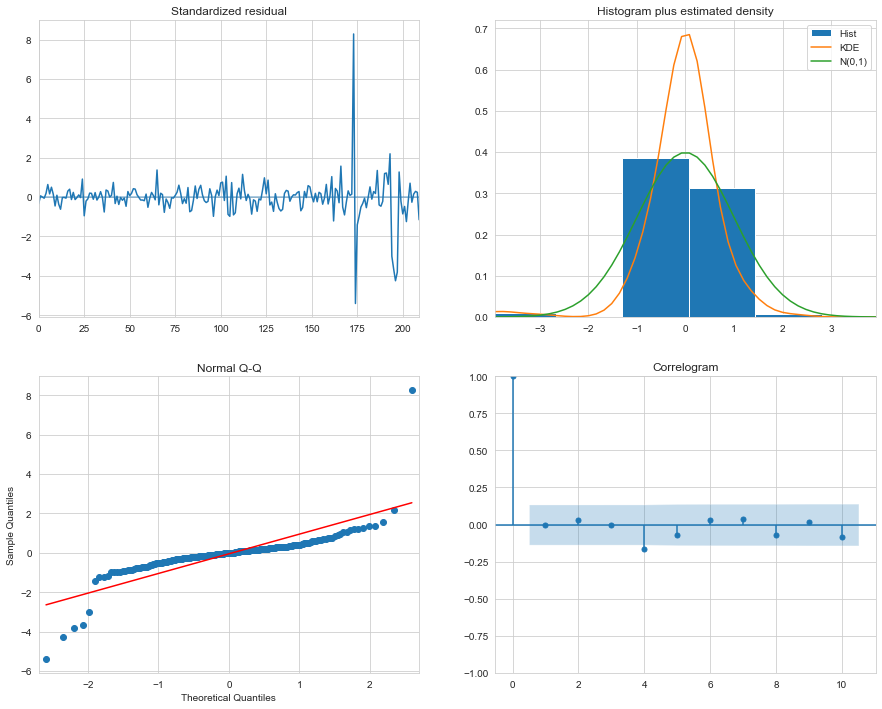

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [14]:
vu_sl = SARIMAXPipeline(data=vu, y_var="Total", exog_var="covid", 
                         transform_method="scaledlogit", training_ratio=0.95)
vu_sl.transform()
vu_sl.stepwise_search()

In [13]:
vu_models = []
vu_sw = vu_sl.stepwise_model
vu_models.append(pm.ARIMA(
    vu_sw["order"], vu_sw["seasonal_order"],  exog=vu_sl.exog[:vu_sl.training_size]))
for res in vu_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=vu_sl.exog[:vu_sl.training_size])
    vu_models.append(model)

vu_comp = vu.compare_models(
    y=vu_sl.transformed_y[:vu_sl.training_size],
    exog=vuvu_slexog[:vu_sl.training_size],
    models=vu_models)

NameError: name 'vu_sl' is not defined

In [14]:
vu_org_comp

NameError: name 'vu_org_comp' is not defined